In [44]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import model_selection
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

In [46]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
INTERIM_DATA_DIR = DATA_DIR / "interim"

In [47]:
try:
    train_data_teams = pd.read_csv(INTERIM_DATA_DIR / "train_data_teams.csv", index_col=0)
    train_data_players = pd.read_csv(INTERIM_DATA_DIR / "train_data_players.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [48]:
train_data_interim = train_data_teams.merge(train_data_players, left_index=True, right_index=True, how='inner')

In [49]:
train_data_interim.shape

(12303, 326)

In [50]:
train_scores = train_scores.loc[train_data_interim.index]
train_new_y = train_scores['AWAY_WINS']

In [51]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data_interim, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [52]:
model = RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

In [56]:
retained_features, dropped_features = keep_top_shap_features(X_train, y_train, model, n_keep=275)

In [57]:
train_data = train_data_interim[retained_features]
train_data.shape

(12303, 275)

In [58]:
dropped_features

{'DIFF_PLAYER_ACCURATE_CROSSES_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_ACCURATE_CROSSES_season_average_mean_goalkeeper',
 'DIFF_PLAYER_ASSISTS_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_BIG_CHANCES_CREATED_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_BIG_CHANCES_CREATED_season_average_mean_goalkeeper',
 'DIFF_PLAYER_BIG_CHANCES_MISSED_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_BIG_CHANCES_MISSED_season_average_mean_goalkeeper',
 'DIFF_PLAYER_BLOCKED_SHOTS_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_BLOCKED_SHOTS_season_average_mean_goalkeeper',
 'DIFF_PLAYER_CLEARANCE_OFFLINE_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_CLEARANCE_OFFLINE_season_average_mean_goalkeeper',
 'DIFF_PLAYER_DISPOSSESSED_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_DISPOSSESSED_season_average_mean_goalkeeper',
 'DIFF_PLAYER_DRIBBLED_ATTEMPTS_5_last_match_average_mean_goalkeeper',
 'DIFF_PLAYER_DRIBBLED_ATTEMPTS_season_average_mean_goalkeeper',
 

In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [60]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

[0]	train-mlogloss:0.68313	eval-mlogloss:0.68745
[1]	train-mlogloss:0.67374	eval-mlogloss:0.68242
[2]	train-mlogloss:0.66465	eval-mlogloss:0.67745
[3]	train-mlogloss:0.65592	eval-mlogloss:0.67287
[4]	train-mlogloss:0.64742	eval-mlogloss:0.66854
[5]	train-mlogloss:0.63913	eval-mlogloss:0.66407
[6]	train-mlogloss:0.63147	eval-mlogloss:0.65984
[7]	train-mlogloss:0.62365	eval-mlogloss:0.65599
[8]	train-mlogloss:0.61645	eval-mlogloss:0.65254
[9]	train-mlogloss:0.60910	eval-mlogloss:0.64932
[10]	train-mlogloss:0.60233	eval-mlogloss:0.64581
[11]	train-mlogloss:0.59558	eval-mlogloss:0.64302
[12]	train-mlogloss:0.58887	eval-mlogloss:0.64044
[13]	train-mlogloss:0.58265	eval-mlogloss:0.63747
[14]	train-mlogloss:0.57625	eval-mlogloss:0.63437
[15]	train-mlogloss:0.57011	eval-mlogloss:0.63219
[16]	train-mlogloss:0.56388	eval-mlogloss:0.62989
[17]	train-mlogloss:0.55742	eval-mlogloss:0.62736
[18]	train-mlogloss:0.55179	eval-mlogloss:0.62554
[19]	train-mlogloss:0.54568	eval-mlogloss:0.62297
[20]	train

In [61]:
X_test_xgb = xgb.DMatrix(X_test)

target = train_scores.loc[X_test.index].copy()
predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)

0.4746

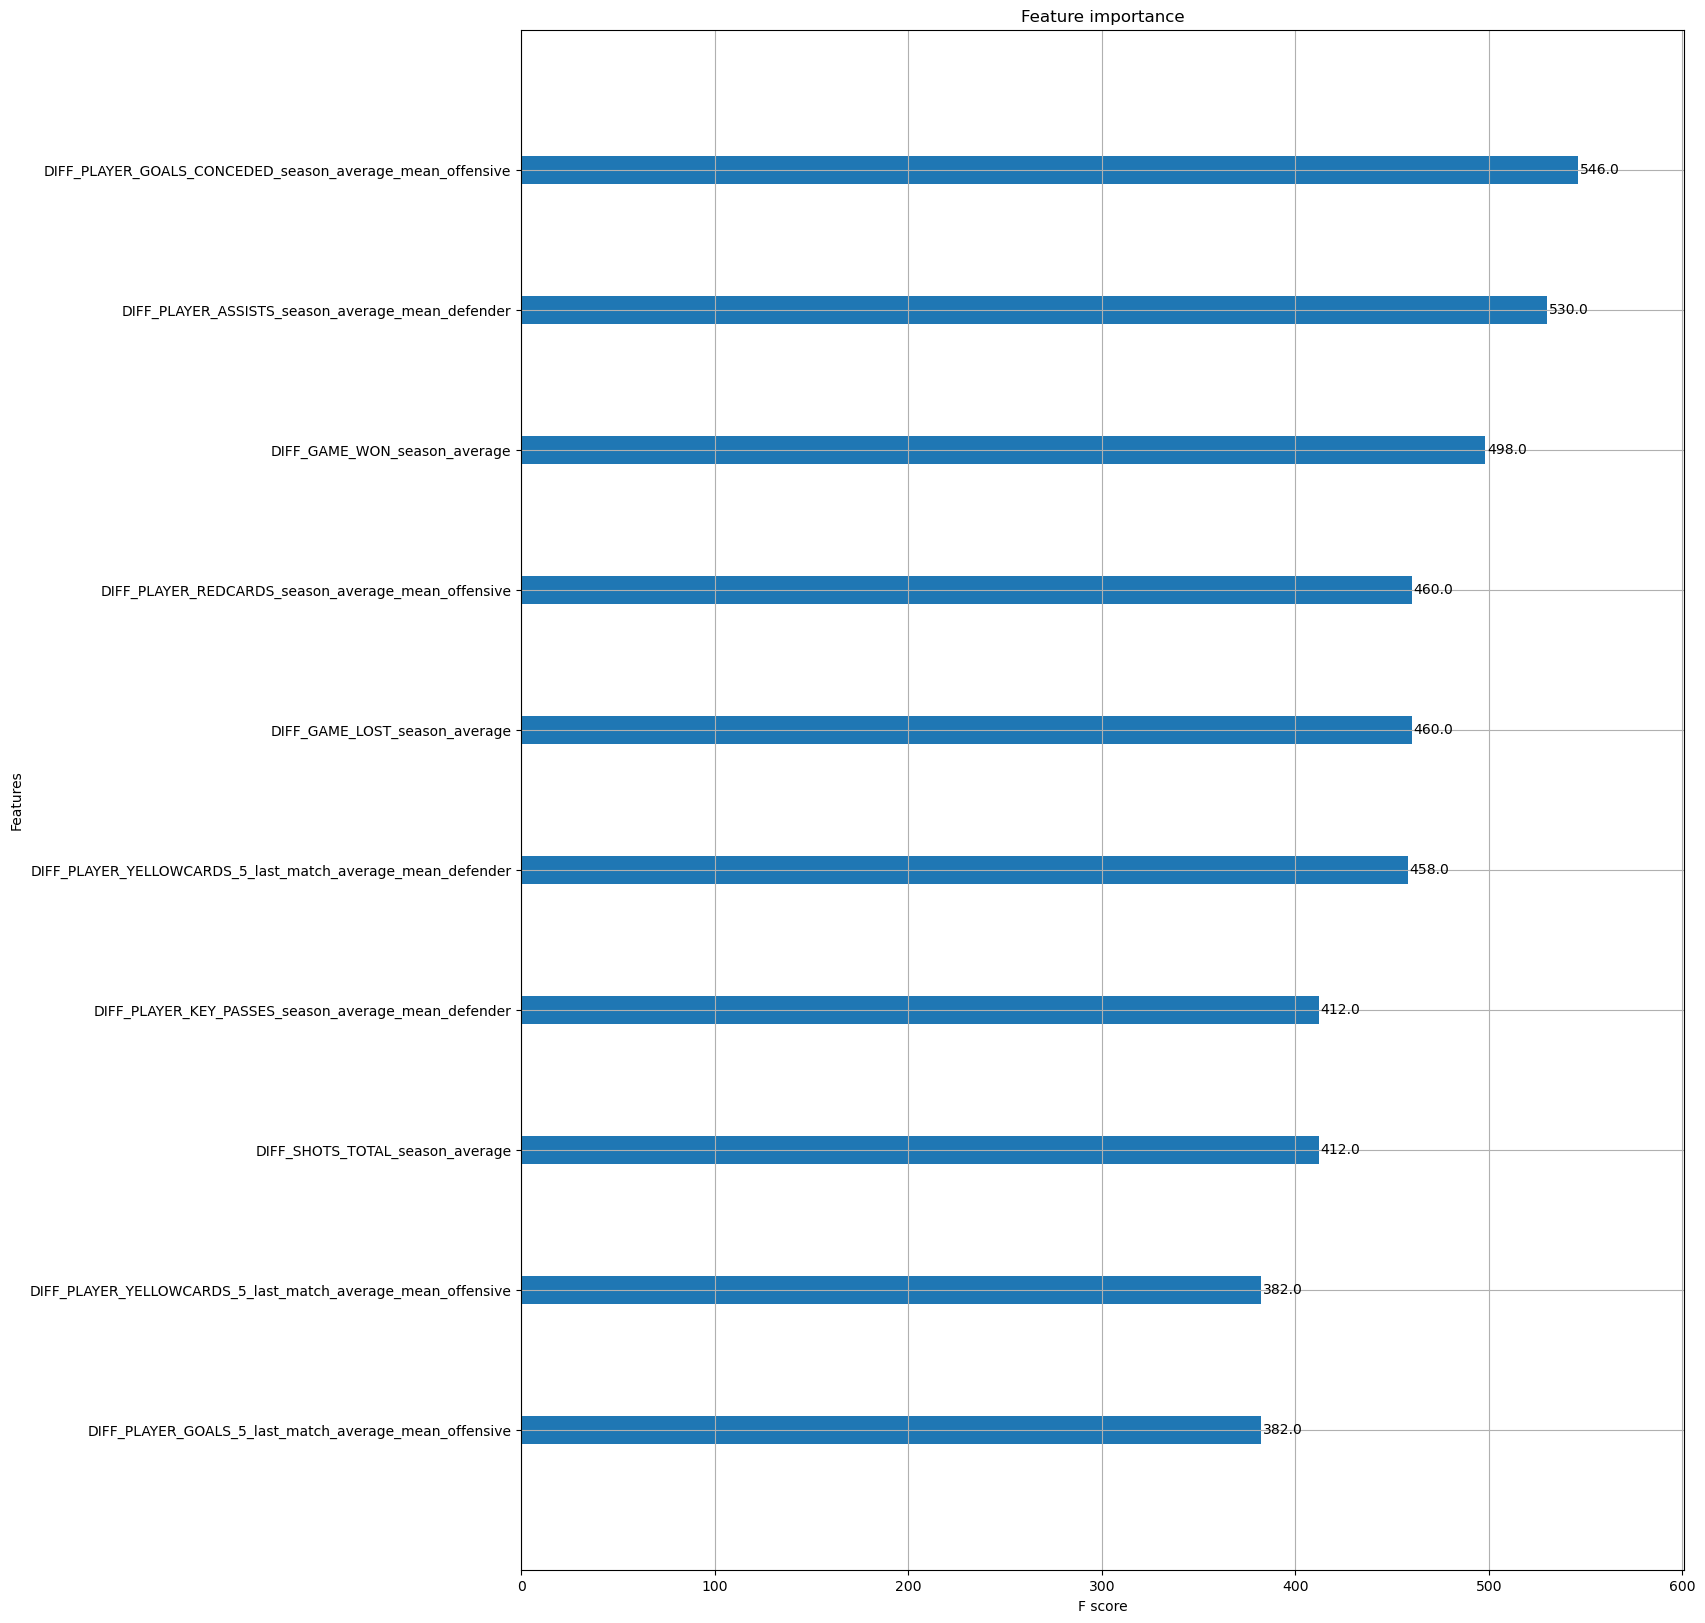

In [62]:
xgb.plot_importance(bst, max_num_features=10)
fig = plt.gcf()
fig.set_size_inches(15, 20)

In [63]:
# {feature_name: score}
importance_dict = bst.get_score(importance_type='weight')
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, score in sorted_features[:10]]
X_reduced = train_data[top_features]


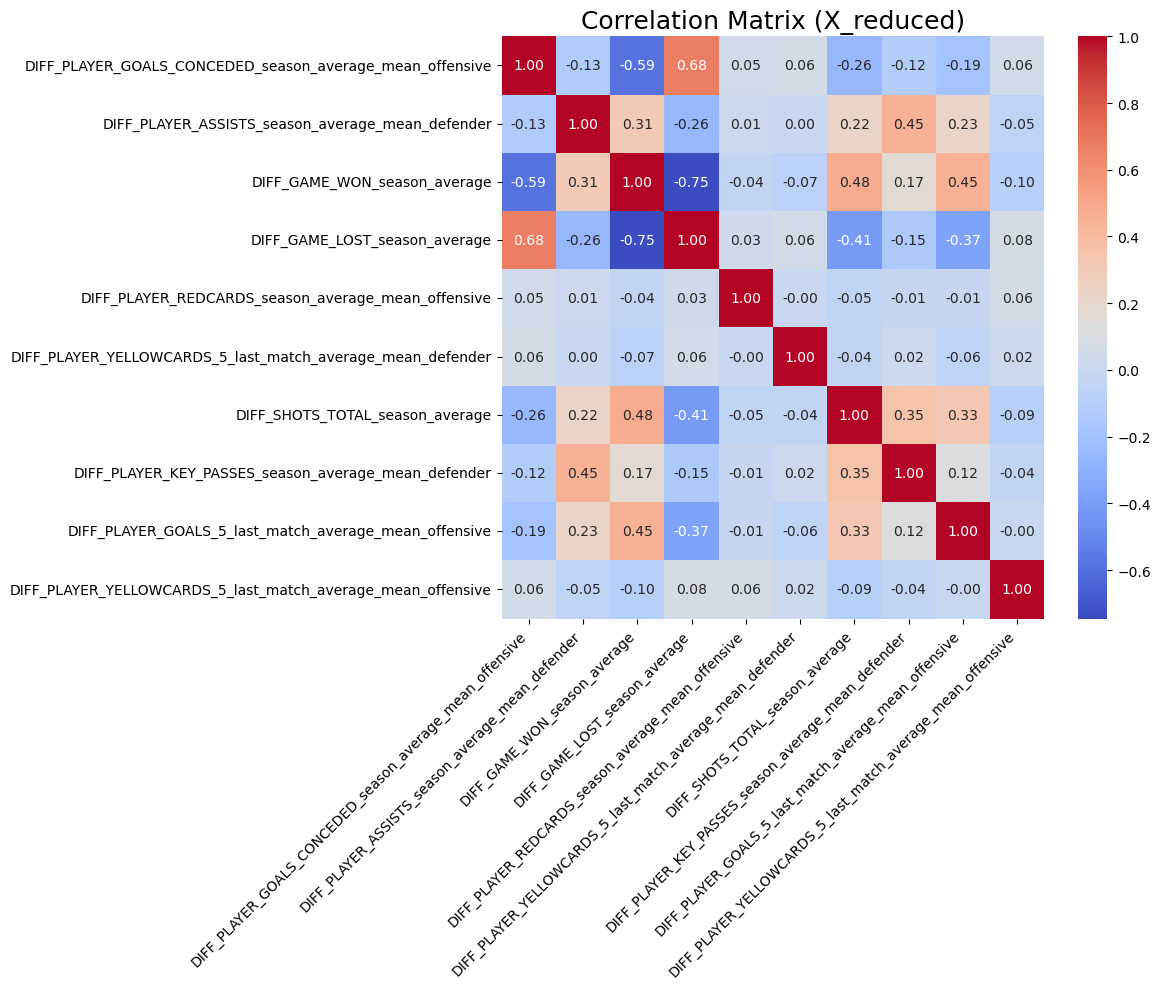

In [64]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

In [65]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns

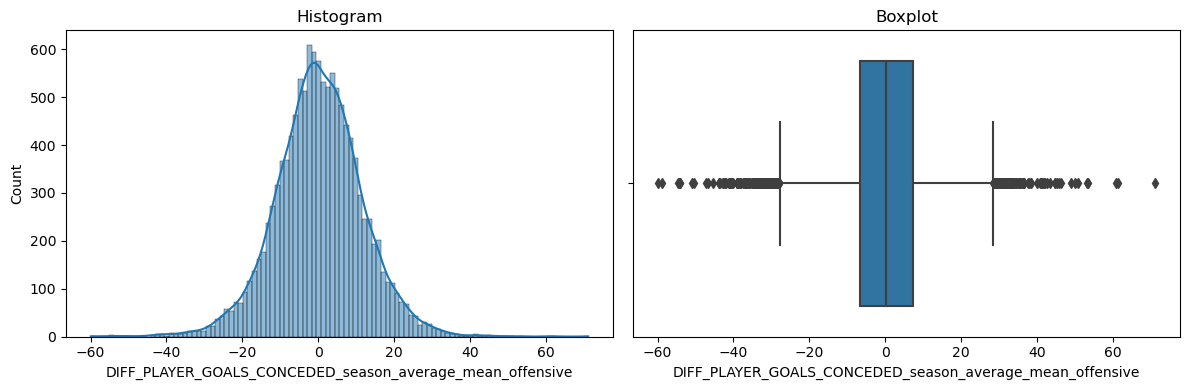

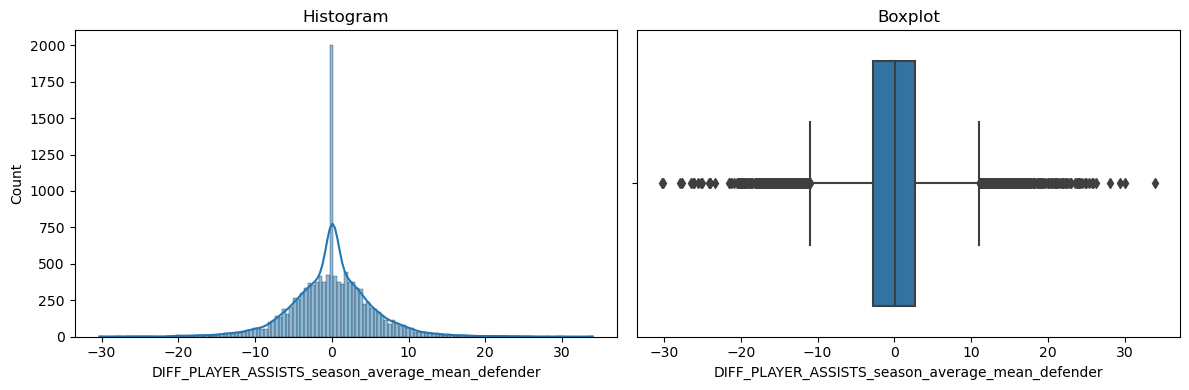

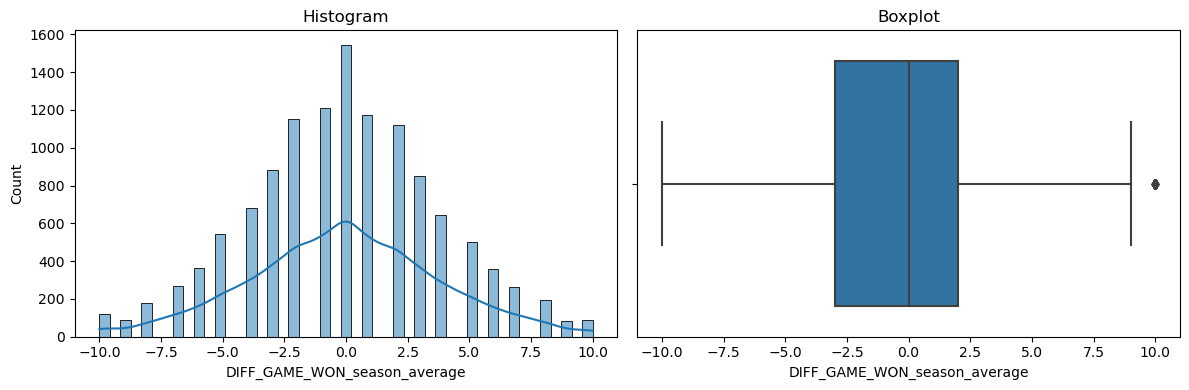

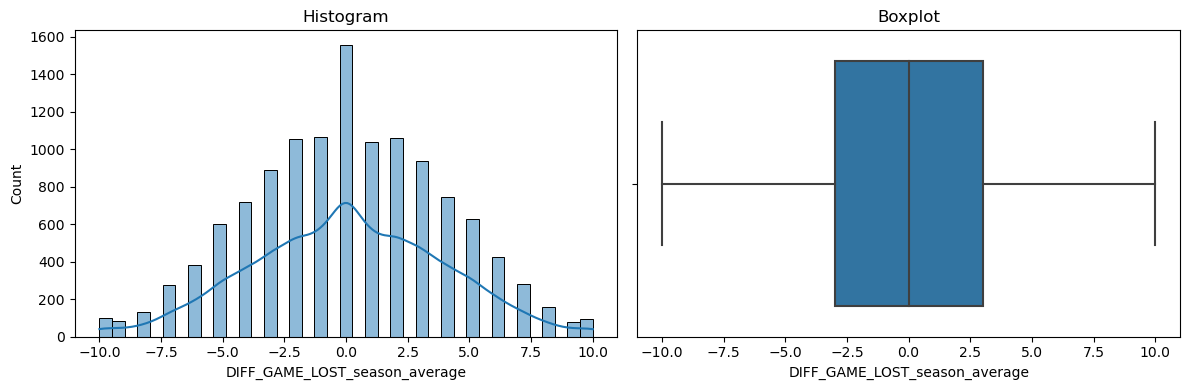

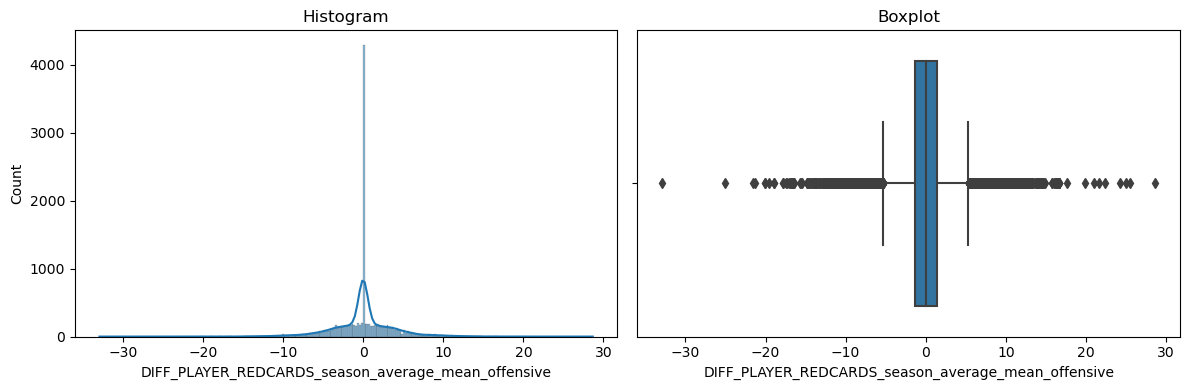

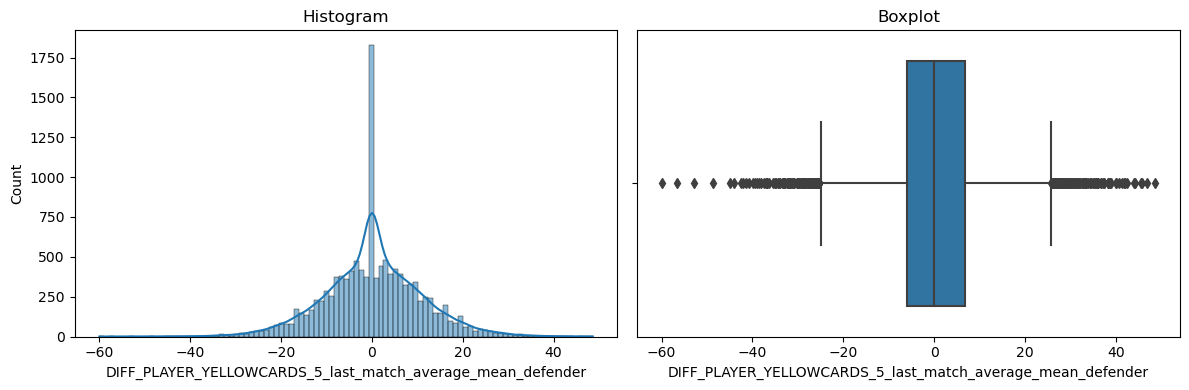

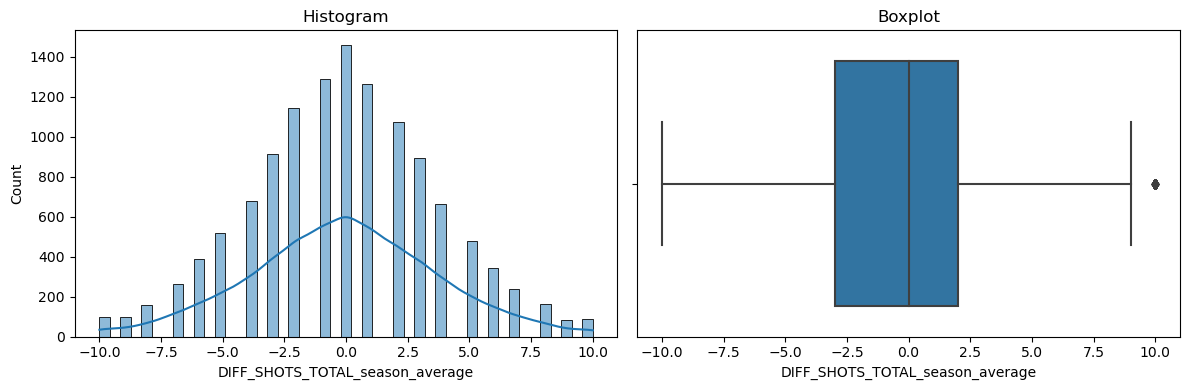

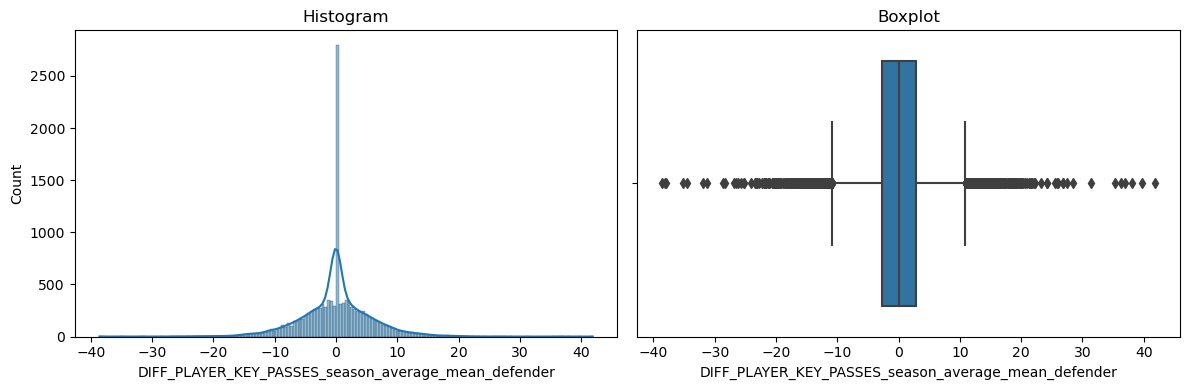

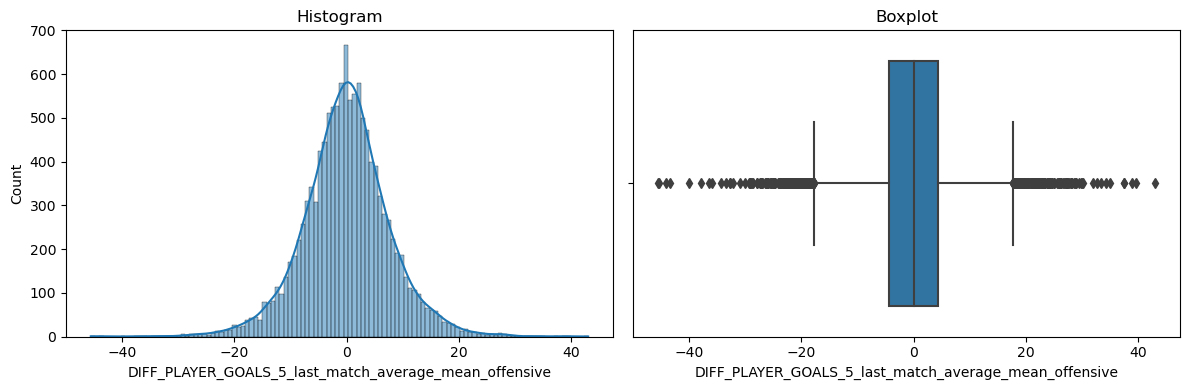

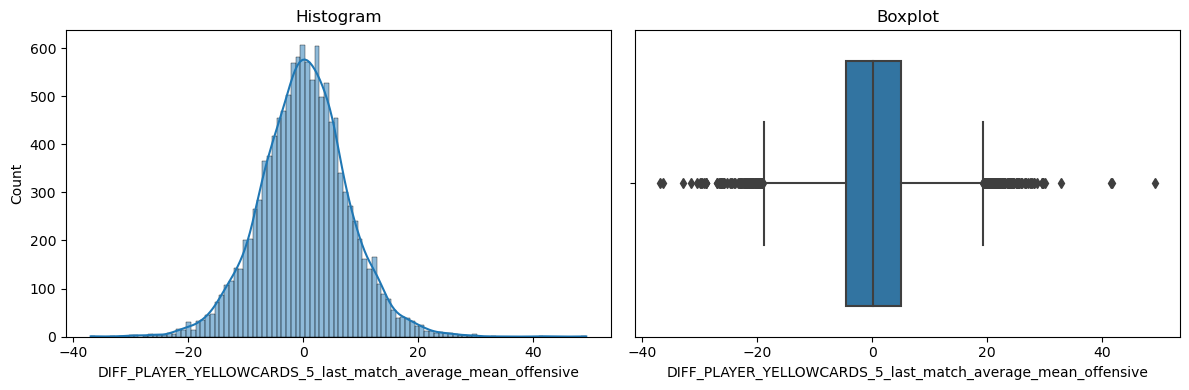

In [66]:
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)

In [67]:
# Store training data

train_data_path = PROCESSED_DATA_DIR / "train_data.csv"
train_data.to_csv(train_data_path, index=True)